In [1]:
%matplotlib inline


===========================================================================
Motor imagery decoding from EEG data using the Common Spatial Pattern (CSP)
===========================================================================

Decoding of motor imagery applied to EEG data decomposed using CSP.
Here the classifier is applied to features extracted on CSP filtered signals.

See http://en.wikipedia.org/wiki/Common_spatial_pattern and [1]_. The EEGBCI
dataset is documented in [2]_. The data set is available at PhysioNet [3]_.

References
----------

.. [1] Zoltan J. Koles. The quantitative extraction and topographic mapping
       of the abnormal components in the clinical EEG. Electroencephalography
       and Clinical Neurophysiology, 79(6):440--447, December 1991.
.. [2] Schalk, G., McFarland, D.J., Hinterberger, T., Birbaumer, N.,
       Wolpaw, J.R. (2004) BCI2000: A General-Purpose Brain-Computer Interface
       (BCI) System. IEEE TBME 51(6):1034-1043.
.. [3] Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG,
       Mietus JE, Moody GB, Peng C-K, Stanley HE. (2000) PhysioBank,
       PhysioToolkit, and PhysioNet: Components of a New Research Resource for
       Complex Physiologic Signals. Circulation 101(23):e215-e220.



In [2]:
# Authors: Martin Billinger <martin.billinger@tugraz.at>
#
# License: BSD (3-clause)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, find_events
from mne.channels import read_layout
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

print(__doc__)

# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.
tmin, tmax = -1., 4.
event_id = dict(hands=2, feet=3)
subject = 1
runs = [6, 10, 14]  # motor imagery: hands vs feet

raw_fnames = eegbci.load_data(subject, runs, path="RawDataMNE")
raw_files = [read_raw_edf(f, preload=True, stim_channel='auto') for f in
             raw_fnames]
raw = concatenate_raws(raw_files)

# strip channel names of "." characters
raw.rename_channels(lambda x: x.strip('.'))

# Apply band-pass filter
raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')

events = find_events(raw, shortest_event=0, stim_channel='STI 014')

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                baseline=None, preload=True)
epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
labels = epochs.events[:, -1] - 2

Automatically created module for IPython interactive environment
Extracting EDF parameters from RawDataMNE/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R06.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T2', 'T1']
Extracting EDF parameters from RawDataMNE/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R10.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
Extracting EDF parameters from RawDataMNE/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R14.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_even

Classification with linear discrimant analysis



Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Classification accuracy: 0.933333 / Chance level: 0.533333
Estimating covariance using EMPIRICAL
Done.
Estimating covari

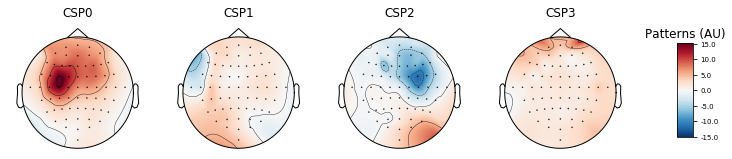

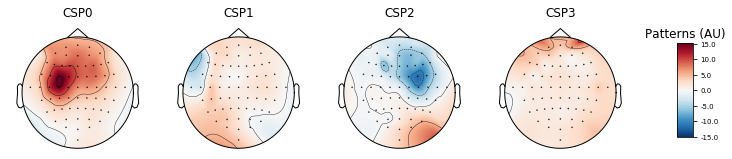

In [3]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

layout = read_layout('EEG1005')
csp.plot_patterns(epochs.info, layout=layout, ch_type='eeg',
                  units='Patterns (AU)', size=1.5)

Look at performance over time



Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.


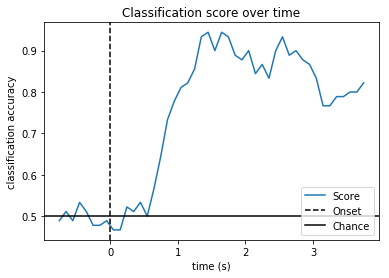

In [4]:
sfreq = raw.info['sfreq']
w_length = int(sfreq * 0.5)   # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()